In [1]:
# This entire module is from SpecRes by A C Carnall
# https://ui.adsabs.harvard.edu/abs/2017arXiv170505165C/abstract

from __future__ import print_function, division, absolute_import

import numpy as np


def make_bins(wavs):
    """ Given a series of wavelength points, find the edges and widths
    of corresponding wavelength bins. """
    edges = np.zeros(wavs.shape[0]+1)
    widths = np.zeros(wavs.shape[0])
    edges[0] = wavs[0] - (wavs[1] - wavs[0])/2
    widths[-1] = (wavs[-1] - wavs[-2])
    edges[-1] = wavs[-1] + (wavs[-1] - wavs[-2])/2
    edges[1:-1] = (wavs[1:] + wavs[:-1])/2
    widths[:-1] = edges[1:-1] - edges[:-2]

    return edges, widths


def spectres(new_wavs, spec_wavs, spec_fluxes, spec_errs=None, fill=None,
             verbose=True):

    """
    Function for resampling spectra (and optionally associated
    uncertainties) onto a new wavelength basis.

    Parameters
    ----------

    new_wavs : numpy.ndarray
        Array containing the new wavelength sampling desired for the
        spectrum or spectra.

    spec_wavs : numpy.ndarray
        1D array containing the current wavelength sampling of the
        spectrum or spectra.

    spec_fluxes : numpy.ndarray
        Array containing spectral fluxes at the wavelengths specified in
        spec_wavs, last dimension must correspond to the shape of
        spec_wavs. Extra dimensions before this may be used to include
        multiple spectra.

    spec_errs : numpy.ndarray (optional)
        Array of the same shape as spec_fluxes containing uncertainties
        associated with each spectral flux value.

    fill : float (optional)
        Where new_wavs extends outside the wavelength range in spec_wavs
        this value will be used as a filler in new_fluxes and new_errs.

    verbose : bool (optional)
        Setting verbose to False will suppress the default warning about
        new_wavs extending outside spec_wavs and "fill" being used.

    Returns
    -------

    new_fluxes : numpy.ndarray
        Array of resampled flux values, first dimension is the same
        length as new_wavs, other dimensions are the same as
        spec_fluxes.

    new_errs : numpy.ndarray
        Array of uncertainties associated with fluxes in new_fluxes.
        Only returned if spec_errs was specified.
    """

    # Rename the input variables for clarity within the function.
    old_wavs = spec_wavs
    old_fluxes = spec_fluxes
    old_errs = spec_errs

    # Make arrays of edge positions and widths for the old and new bins

    old_edges, old_widths = make_bins(old_wavs)
    new_edges, new_widths = make_bins(new_wavs)

    # Generate output arrays to be populated
    new_fluxes = np.zeros(old_fluxes[..., 0].shape + new_wavs.shape)

    if old_errs is not None:
        if old_errs.shape != old_fluxes.shape:
            raise ValueError("If specified, spec_errs must be the same shape "
                             "as spec_fluxes.")
        else:
            new_errs = np.copy(new_fluxes)

    start = 0
    stop = 0
    warned = False

    # Calculate new flux and uncertainty values, looping over new bins
    for j in range(new_wavs.shape[0]):

        # Add filler values if new_wavs extends outside of spec_wavs
        if (new_edges[j] < old_edges[0]) or (new_edges[j+1] > old_edges[-1]):
            new_fluxes[..., j] = fill

            if spec_errs is not None:
                new_errs[..., j] = fill

            if (j == 0 or j == new_wavs.shape[0]-1) and verbose and not warned:
                warned = True
                print("\nSpectres: new_wavs contains values outside the range "
                      "in spec_wavs, new_fluxes and new_errs will be filled "
                      "with the value set in the 'fill' keyword argument. \n")
            continue

        # Find first old bin which is partially covered by the new bin
        while old_edges[start+1] <= new_edges[j]:
            start += 1

        # Find last old bin which is partially covered by the new bin
        while old_edges[stop+1] < new_edges[j+1]:
            stop += 1

        # If new bin is fully inside an old bin start and stop are equal
        if stop == start:
            new_fluxes[..., j] = old_fluxes[..., start]
            if old_errs is not None:
                new_errs[..., j] = old_errs[..., start]

        # Otherwise multiply the first and last old bin widths by P_ij
        else:
            start_factor = ((old_edges[start+1] - new_edges[j])
                            / (old_edges[start+1] - old_edges[start]))

            end_factor = ((new_edges[j+1] - old_edges[stop])
                          / (old_edges[stop+1] - old_edges[stop]))

            old_widths[start] *= start_factor
            old_widths[stop] *= end_factor

            # Populate new_fluxes spectrum and uncertainty arrays
            f_widths = old_widths[start:stop+1]*old_fluxes[..., start:stop+1]
            new_fluxes[..., j] = np.sum(f_widths, axis=-1)
            new_fluxes[..., j] /= np.sum(old_widths[start:stop+1])

            if old_errs is not None:
                e_wid = old_widths[start:stop+1]*old_errs[..., start:stop+1]

                new_errs[..., j] = np.sqrt(np.sum(e_wid**2, axis=-1))
                new_errs[..., j] /= np.sum(old_widths[start:stop+1])

            # Put back the old bin widths to their initial values
            old_widths[start] /= start_factor
            old_widths[stop] /= end_factor

    # If errors were supplied return both new_fluxes and new_errs.
    if old_errs is not None:
        return new_fluxes, new_errs

    # Otherwise just return the new_fluxes spectrum array
    else:
        return new_fluxes


In [87]:
# imports and initialize seeds, fundamental constants
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt

np.random.seed(17)
c = 299792458. # m / s
sqrt2pi = np.sqrt(2. * np.pi)

from ndi import resample_spectrum

# make the synthetic spectrum (spectral expectation), and also add noise

def oned_gaussian(dxs, sigma):
    return np.exp(-0.5 * dxs ** 2 / sigma ** 2) / (sqrt2pi * sigma)

def true_spectrum(xs, doppler, lxs, ews, sigma):
    """
    """
    return np.exp(-1. * np.sum(ews[None, :] *
                               oned_gaussian(xs[:, None] - doppler
                                             - lxs[None, :], sigma), axis=1))

def ivar(ys, continuum_ivar):
    return continuum_ivar / ys

def noisy_true_spectrum(xs, doppler, continuum_ivar, line_xs, line_ews, sigma_x):
    """
    """
    ys_true = true_spectrum(xs, doppler, line_xs, line_ews, sigma_x)
    y_ivars = ivar(ys_true, continuum_ivar)
    return  (ys_true + np.random.normal(size=xs.shape) / np.sqrt(y_ivars), y_ivars)

def doppler_information(xs, doppler, continuum_ivar, dx):
    """
    # Bugs:
    - Horrifying numerical derivative!
    """
    dys_dx = (true_spectrum(xs, doppler + dx)
              - true_spectrum(xs, doppler - dx)) / (2. * dx)
    y_ivars = ivar(true_spectrum(xs, doppler), continuum_ivar)
    return np.sum(y_ivars * dys_dx ** 2)

def badify(yy, badfrac):
    """
    Make bad-pixel masks and badify the bad pixels.
    """
    bady = 1. * yy
    bs = (np.random.uniform(size=len(bady)) > badfrac).astype(int)
    bs = np.minimum(bs, np.roll(bs, 1))
    bs = np.minimum(bs, np.roll(bs, -1))
    nbad = np.sum(bs < 0.5)
    if nbad > 0:
        bady[bs < 0.5] += 2. * np.random.uniform(size=nbad)
    return bs, bady

def make_one_dataset(dx, SNR, x_min, x_max, line_xs, line_ews, sigma_x, badfrac, xstar, N=8):
    # create true Doppler shifts on a sinusoid of epoch number
    Delta_xs = (3.e4 / c) * np.cos(np.arange(N) / 3.)
    # set the ivar
    continuum_ivar = SNR ** 2 # inverse variance of the noise in the continuum
    # now make the noisy fake data
    xs = np.arange(x_min - 0.5 * dx, x_max + dx, dx)
    ys = np.zeros((N, len(xs)))
    y_ivars = np.zeros_like(ys)
    bs = np.zeros_like(ys).astype(int)
    y_true = true_spectrum(xstar, 0, line_xs, line_ews, sigma_x)
    for j in range(N):
        ys[j], y_ivars[j] = noisy_true_spectrum(xs, Delta_xs[j], continuum_ivar, line_xs, line_ews, sigma_x)
        bs[j], ys[j] = badify(ys[j], badfrac)
    return xs, ys, y_ivars, bs, Delta_xs, y_true


# Estimate covariances from just one trial:
def covariances(resids):
    lags = np.arange(12)
    var = np.zeros(len(lags)) + np.NaN
    var[0] = np.mean(resids * resids)
    for lag in lags[1:]:
        var[lag] = np.mean(resids[lag:] * resids[:-lag])
    return lags, var

def get_poorly_sampled_regime_data():
    # define high-level parameters, especially including spectrograph parameters
    R = 1.35e5 # resolution
    sigma_x = 1. / R # LSF sigma in x units
    x_min = 8.7000 # minimum ln wavelength
    x_max = 8.7025 # maximum ln wavelength
    lines_per_x = 2.0e4 # mean density (Poisson rate) of lines per unit ln wavelength
    ew_max_x = 3.0e-5 # maximum equivalent width in x units
    ew_power = 5.0 # power parameter in EW maker
    badfrac = 0.01 # fraction of data to mark bad
    # Set the pixel grid and model complexity for the output combined spectrum
    dxstar = 1. / R # output pixel grid spacing
    xstar = np.arange(x_min + 0.5 * dxstar, x_max, dxstar) # output pixel grid
    Mstar = len(xstar) # number of output pixels
    P = np.round((x_max - x_min) * R).astype(int) # number of Fourier modes (ish)

    # set up the line list for the true spectral model
    x_margin = 1.e6/c # hoping no velocities are bigger than 1000 km/s
    x_range = x_max - x_min + 2. * x_margin # make lines in a bigger x range than the data range
    nlines = np.random.poisson(x_range * lines_per_x) # set the total number of lines
    line_xs = (x_min - x_margin) + x_range * np.random.uniform(size=nlines)

    # give those lines equivalent widths from a power-law distribution
    line_ews = ew_max_x * np.random.uniform(size=nlines) ** ew_power # don't ask

    dx1 = 2. / R # pixel spacing in the poorly sampled data; UNDER-SAMPLED!
    SNR1 = 18. # s/n ratio per pixel in the continuum
    xs1, ys1, y_ivars1, bs1, Delta_xs1, y_true = make_one_dataset(dx1, SNR1, x_min, x_max, line_xs, line_ews, sigma_x, badfrac, xstar)

    return (dx1, SNR1, xs1, ys1, y_ivars1, bs1, Delta_xs1, xstar, y_true, line_xs, line_ews, sigma_x)




def get_well_sampled_regime_data():
    R = 1.35e5 # resolution
    sigma_x = 1. / R # LSF sigma in x units
    x_min = 8.7000 # minimum ln wavelength
    x_max = 8.7025 # maximum ln wavelength
    lines_per_x = 2.0e4 # mean density (Poisson rate) of lines per unit ln wavelength
    ew_max_x = 3.0e-5 # maximum equivalent width in x units
    ew_power = 5.0 # power parameter in EW maker
    badfrac = 0.01 # fraction of data to mark bad
    # Set the pixel grid and model complexity for the output combined spectrum
    dxstar = 1. / R # output pixel grid spacing
    xstar = np.arange(x_min + 0.5 * dxstar, x_max, dxstar) # output pixel grid
    Mstar = len(xstar) # number of output pixels
    P = np.round((x_max - x_min) * R).astype(int) # number of Fourier modes (ish)

    # set up the line list for the true spectral model
    x_margin = 1.e6/c # hoping no velocities are bigger than 1000 km/s
    x_range = x_max - x_min + 2. * x_margin # make lines in a bigger x range than the data range
    nlines = np.random.poisson(x_range * lines_per_x) # set the total number of lines
    line_xs = (x_min - x_margin) + x_range * np.random.uniform(size=nlines)

    # give those lines equivalent widths from a power-law distribution
    line_ews = ew_max_x * np.random.uniform(size=nlines) ** ew_power # don't ask

    dx2 = 1. / R # pixel spacing in the poorly sampled data; UNDER-SAMPLED!
    SNR2 = 12. # s/n ratio per pixel in the continuum
    xs2, ys2, y_ivars2, bs2, Delta_xs2, y_true = make_one_dataset(dx2, SNR2,  x_min, x_max, line_xs, line_ews, sigma_x, badfrac, xstar)

    return (dx2, SNR2, xs2, ys2, y_ivars2, bs2, Delta_xs2, xstar, y_true, line_xs, line_ews, sigma_x)


In [31]:
from scipy import interpolate

def wave_to_pixel(wave, wave0):
    """convert wavelength to pixel given wavelength array
    Args :
       wave(s) : wavelength(s) (\AA) to get pixel of
       wave0 : array with wavelength as a function of pixel number
    Returns :
       pixel(s) in the chip
    """
    pix0 = np.arange(len(wave0))
    # Need to sort into ascending order
    sindx = np.argsort(wave0)
    wave0 = wave0[sindx]
    pix0 = pix0[sindx]
    # Start from a linear baseline
    baseline = np.polynomial.Polynomial.fit(wave0, pix0, 1)
    ip = interpolate.InterpolatedUnivariateSpline(wave0, pix0 / baseline(wave0), k=3)
    out = baseline(wave) * ip(wave)
    # NaN for out of bounds
    out[wave > wave0[-1]] = np.nan
    out[wave < wave0[0]] = np.nan
    return out


def sincint(x, nres, speclist):
    """Use sinc interpolation to get resampled values
    x : desired positions
    nres : number of pixels per resolution element (2=Nyquist)
    speclist : list of [quantity, variance] pairs (variance can be None)

    NOTE: This takes in variance, but returns ERROR.
    """

    dampfac = 3.25 * nres / 2.0
    ksize = int(21 * nres / 2.0)
    if ksize % 2 == 0:
        ksize += 1
    nhalf = ksize // 2

    # number of output and input pixels
    nx = len(x)
    nf = len(speclist[0][0])

    # integer and fractional pixel location of each output pixel
    ix = x.astype(int)
    fx = x - ix

    # outputs
    outlist = []
    for spec in speclist:
        if spec[1] is None:
            outlist.append([np.full_like(x, 0), None])
        else:
            outlist.append([np.full_like(x, 0), np.full_like(x, 0)])

    for i in range(len(x)):
        xkernel = np.arange(ksize) - nhalf - fx[i]
        # in units of Nyquist
        xkernel /= nres / 2.0
        u1 = xkernel / dampfac
        u2 = np.pi * xkernel
        sinc = np.exp(-(u1**2)) * np.sin(u2) / u2
        sinc /= nres / 2.0

        # the sinc function value at x = 0 is defined by the limit, -> 1
        sinc[u2 == 0] = 1

        lobe = np.arange(ksize) - nhalf + ix[i]
        vals = np.zeros(ksize)
        gd = np.where((lobe >= 0) & (lobe < nf))[0]

        for spec, out in zip(speclist, outlist):
            vals = spec[0][lobe[gd]]
            out[0][i] = (sinc[gd] * vals).sum()
            if spec[1] is not None:
                var = spec[1][lobe[gd]]
                out[1][i] = (sinc[gd] ** 2 * var).sum()

    for out in outlist:
        if out[1] is not None:
            out[1] = np.sqrt(out[1])

    return outlist


poorly sampled input 8 171 18.0


NameError: name 'name' is not defined

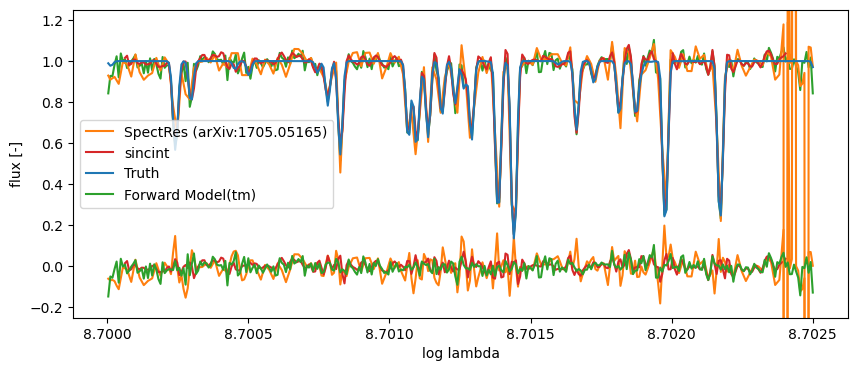

In [88]:
np.random.seed(17)

(dx1, SNR1, xs1, ys1, y_ivars1, bs1, Delta_xs1, xstar, y_true, line_xs, line_ews, sigma_x) = get_poorly_sampled_regime_data()

    
M1 = len(xs1)
N1 = len(ys1)
name1 = "poorly sampled input"
print(name1, N1, M1, SNR1)

x = []
for delta_xs in Delta_xs1:
    x.extend(xs1 - delta_xs)

x = np.array(x)
y = ys1.flatten()

spec_errs = np.sqrt(1. / y_ivars1).flatten()
mask = ~(bs1.flatten() != 1)

spectres_flux, spectres_e_flux = spectres(xstar, x[mask], y[mask], spec_errs=spec_errs[mask])

sincint_flux = np.nan * np.ones((ys1.shape[0], xstar.size), dtype=float)
sincint_e_flux = np.nan * np.ones((ys1.shape[0], xstar.size), dtype=float)


for i in range(ys1.shape[0]):

    mask = ~(bs1[i] != 1)

    pixel = wave_to_pixel(xstar, xs1 - Delta_xs1[i])
    
    y_var = 1/y_ivars1[i].copy()
    finite = np.isfinite(pixel)

    yh = ys1[i].copy()
    yh[~mask] = 1
    y_var[~mask] = 1e30

    ((sincint_flux_, sincint_e_flux_), ) = sincint(
        pixel[finite], 2.0, [
            [yh, y_var]
        ]
    )
    sincint_flux[i, finite] = sincint_flux_
    sincint_e_flux[i, finite] = sincint_e_flux_

sincint_ivar = sincint_e_flux**-2
sincint_ivar[~np.isfinite(sincint_ivar)] = 0
sum_sincint_flux = np.sum(sincint_flux * sincint_ivar, axis=0) / np.sum(sincint_ivar, axis=0)

y_star, Cinv_star, _ = resample_spectrum(xstar, x, ys1.flatten(), y_ivars1.flatten(), mask=(bs1.flatten() != 1))

z = (y_star - y_true) * np.sqrt(Cinv_star)


fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(xstar, y_star, c='tab:green')
ax.plot(xstar, spectres_flux - y_true, c="tab:orange")
ax.plot(xstar, sum_sincint_flux - y_true, c="tab:red")
ax.plot(xstar, spectres_flux, c="tab:orange", label="SpectRes (arXiv:1705.05165)")
ax.plot(xstar, sum_sincint_flux, c="tab:red", label="sincint")
ax.plot(xstar, y_true, c="tab:blue", label="Truth")
ax.plot(xstar, y_star - y_true, c="tab:green", label="Forward Model(tm)")



'''
for i, xs in enumerate(Delta_xs1):
    ax.plot(xs1 - xs, ys1[i] + i + 1, c='#666666')
    ax.plot(xstar, sincint_flux[i] + i + 1, c="tab:red")
'''
#ax.set_ylim(-0.25, 11)#1.25)
ax.set_ylim(-0.25, 1.25)

ax.set_xlabel("log lambda")
ax.set_ylabel("flux [-]")
ax.legend()
ax.set_title(name)
    
#assert np.abs(np.mean(z)) < 0.15
#assert np.abs(np.std(z) - 1) < 0.05


In [92]:
np.random.seed(17)

(dx1, SNR1, xs1, ys1, y_ivars1, bs1, Delta_xs1, xstar, y_true, line_xs, line_ews, sigma_x) = get_well_sampled_regime_data()

    
M1 = len(xs1)
N1 = len(ys1)
name1 = "well sampled input"
print(name1, N1, M1, SNR1)

x = []
for delta_xs in Delta_xs1:
    x.extend(xs1 - delta_xs)

x = np.array(x)
y = ys1.flatten()

spec_errs = np.sqrt(1. / y_ivars1).flatten()
mask = ~(bs1.flatten() != 1)

spectres_flux, spectres_e_flux = spectres(xstar, x[mask], y[mask], spec_errs=spec_errs[mask])

def do_sincint(xstar, xs1, Delta_xs1, ys1, y_ivars1, bs1):
        
    sincint_flux = np.nan * np.ones((ys1.shape[0], xstar.size), dtype=float)
    sincint_e_flux = np.nan * np.ones((ys1.shape[0], xstar.size), dtype=float)


    for i in range(ys1.shape[0]):

        mask = ~(bs1[i] != 1)

        pixel = wave_to_pixel(xstar, xs1 - Delta_xs1[i])
        
        y_var = 1/y_ivars1[i].copy()
        finite = np.isfinite(pixel)

        yh = ys1[i].copy()
        yh[~mask] = 1
        y_var[~mask] = 1e30

        ((sincint_flux_, sincint_e_flux_), ) = sincint(
            pixel[finite], 2.0, [
                [yh, y_var]
            ]
        )
        sincint_flux[i, finite] = sincint_flux_
        sincint_e_flux[i, finite] = sincint_e_flux_

    sincint_ivar = sincint_e_flux**-2
    sincint_ivar[~np.isfinite(sincint_ivar)] = 0
    sum_sincint_flux = np.sum(sincint_flux * sincint_ivar, axis=0) / np.sum(sincint_ivar, axis=0)

    return sum_sincint_flux


sum_sincint_flux = do_sincint(xstar, xs1, Delta_xs1, ys1, y_ivars1, bs1)

y_star, Cinv_star, _ = resample_spectrum(xstar, x, ys1.flatten(), y_ivars1.flatten(), mask=(bs1.flatten() != 1))

z = (y_star - y_true) * np.sqrt(Cinv_star)


fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(xstar, y_star, c='tab:green')
ax.plot(xstar, spectres_flux - y_true, c="tab:orange")
ax.plot(xstar, sum_sincint_flux - y_true, c="tab:red")
ax.plot(xstar, spectres_flux, c="tab:orange", label="SpectRes (arXiv:1705.05165)")
ax.plot(xstar, sum_sincint_flux, c="tab:red", label="sincint")
ax.plot(xstar, y_true, c="tab:blue", label="Truth")
ax.plot(xstar, y_star - y_true, c="tab:green", label="Forward Model(tm)")



'''
for i, xs in enumerate(Delta_xs1):
    ax.plot(xs1 - xs, ys1[i] + i + 1, c='#666666')
    ax.plot(xstar, sincint_flux[i] + i + 1, c="tab:red")
'''
#ax.set_ylim(-0.25, 11)#1.25)
ax.set_ylim(-0.25, 1.25)

ax.set_xlabel("log lambda")
ax.set_ylabel("flux [-]")
ax.legend()
ax.set_title(name1)
    
#assert np.abs(np.mean(z)) < 0.15
#assert np.abs(np.std(z) - 1) < 0.05


well sampled input 8 340 12.0


TypeError: do_sincint() missing 1 required positional argument: 'bs1'

Text(0.5, 1.0, 'covariances estimated from 64 trials')

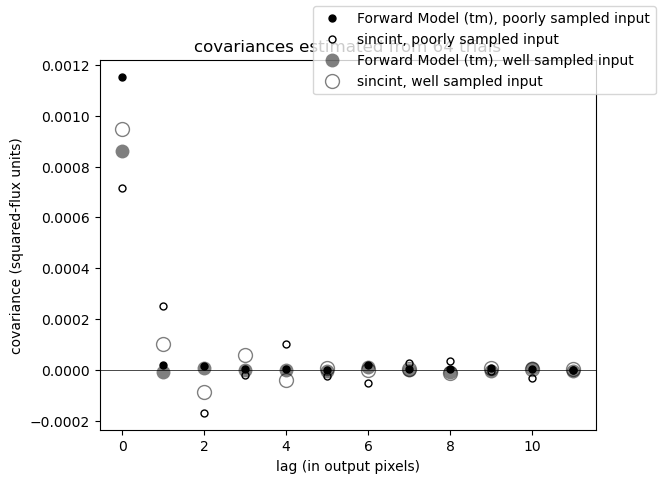

In [95]:
# Estimate using multiple repeated experiments
#(dx1, SNR1, xs1, ys1, y_ivars1, bs1, Delta_xs1, xstar, y_true1, line_xs, line_ews, sigma_x) = get_poorly_sampled_regime_data()
#(dx2, SNR2, xs2, ys2, y_ivars2, bs2, Delta_xs2, xstar, y_true2, line_xs, line_ews, sigma_x) = get_well_sampled_regime_data()
R = 1.35e5 # resolution
sigma_x = 1. / R # LSF sigma in x units
x_min = 8.7000 # minimum ln wavelength
x_max = 8.7025 # maximum ln wavelength
lines_per_x = 2.0e4 # mean density (Poisson rate) of lines per unit ln wavelength
ew_max_x = 3.0e-5 # maximum equivalent width in x units
ew_power = 5.0 # power parameter in EW maker
badfrac = 0.01 # fraction of data to mark bad
# Set the pixel grid and model complexity for the output combined spectrum
dxstar = 1. / R # output pixel grid spacing
xstar = np.arange(x_min + 0.5 * dxstar, x_max, dxstar) # output pixel grid
Mstar = len(xstar) # number of output pixels
P = np.round((x_max - x_min) * R).astype(int) # number of Fourier modes (ish)

# set up the line list for the true spectral model
x_margin = 1.e6/c # hoping no velocities are bigger than 1000 km/s
x_range = x_max - x_min + 2. * x_margin # make lines in a bigger x range than the data range
nlines = np.random.poisson(x_range * lines_per_x) # set the total number of lines
line_xs = (x_min - x_margin) + x_range * np.random.uniform(size=nlines)

# give those lines equivalent widths from a power-law distribution
line_ews = ew_max_x * np.random.uniform(size=nlines) ** ew_power # don't ask
dx1 = 2. / R # pixel spacing in the poorly sampled data; UNDER-SAMPLED!
SNR1 = 18. # s/n ratio per pixel in the continuum
dx2 = 1. / R # pixel spacing in the poorly sampled data; UNDER-SAMPLED!
SNR2 = 12. # s/n ratio per pixel in the continuum

name1 = "poorly sampled input"
name2 = "well sampled input"
ntrial = 64
for i, dx, SNR in [(1, dx1, SNR1),
                (2, dx2, SNR2)]:
    numerator = 0.
    numerator_sp = 0.
    for trial in range(ntrial):
        xs, ys, y_ivars, bs, Delta_xs, y_true = make_one_dataset(dx, SNR, x_min, x_max, line_xs, line_ews, sigma_x, badfrac, xstar)
        x = []
        for delta_xs in Delta_xs:
            x.extend(xs - delta_xs)

        y_star, Cinv_star, _ = resample_spectrum(xstar, x, ys.flatten(), y_ivars.flatten(), mask=(bs.flatten() != 1))

        #ystar_sp, foo, bar = Standard_Practice_tm(xs, ys, bs, Delta_xs, xstar)
        ystar_sp = do_sincint(xstar, xs, Delta_xs, ys, y_ivars, bs)
        
        lags, covars = covariances(y_star - y_true)
        # sometimes standard practice will have nans at the edge
        finite_sp = ystar_sp - y_true
        lags, covars_sp = covariances((ystar_sp - y_true)[np.isfinite(finite_sp)])
        assert np.all(np.isfinite(covars_sp))
        assert np.all(np.isfinite(covars))

        numerator += covars
        numerator_sp += covars_sp

    if i == 1:
        covars1 = numerator / ntrial
        covars_sp1 = numerator_sp / ntrial
    elif i == 2:
        covars2 = numerator / ntrial
        covars_sp2 = numerator_sp / ntrial    

# the forward model should have a lower mean covariance
#assert np.mean(np.abs(covars1)[1:]) < np.mean(np.abs(covars_sp1)[1:])
#assert np.mean(np.abs(covars2)[1:]) < np.mean(np.abs(covars_sp2)[1:])


fig, ax = plt.subplots()
ax.axhline(0., color="k", lw=0.5)
ax.plot(lags, covars1, "ko", ms=5,
        label="Forward Model (tm), " + name1)
ax.plot(lags, covars_sp1, "ko", ms=5, mfc="none",
        label="sincint, " + name1)
ax.plot(lags, covars2, "ko", ms=10, alpha=0.5, mec="none",
        label="Forward Model (tm), " + name2)
ax.plot(lags, covars_sp2, "ko", ms=10, alpha=0.5, mfc="none",
        label="sincint, " + name2)
fig.legend()
ax.set_xlabel("lag (in output pixels)")
ax.set_ylabel("covariance (squared-flux units)")
ax.set_title("covariances estimated from {} trials".format(ntrial))